## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtra (np. 21).

2. Stwórz okno np. Hamminga (`np.hamming`) o zadanym rozmiarze.

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:
        hanning2d = np.outer(hanning, hanning)

4. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.

5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.

        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

# Load required files
if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/lena.bmp --no-check-certificate

I_lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)      
        
print(I_lena.shape)

(512, 512)


In [2]:
def plot_3(img,img1,img2):
    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6))
    ax1.imshow(img, 'gray')
    ax1.axis('off')
    ax2.imshow(img1, 'gray')
    ax2.axis('off')
    ax3.imshow(img2, 'gray')
    ax3.axis('off')
    ax1.set_title('Obraz nr1')
    ax2.set_title('Obraz nr2')
    ax3.set_title('Obraz nr3')

In [3]:
def inversja(F_img):
    img_shifted = np.fft.ifftshift(F_img, [0,1])
    ifft = cv2.idft(img_shifted, flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
    img_ifft = cv2.magnitude(ifft[:, :, 0], ifft[:, :, 1])
    img_odwr= np.round(img_ifft).astype('uint8')
    return img_odwr

In [4]:
def fourier1(image):
    image = image.astype("float32")
    F_fcn = cv2.dft(image,flags=cv2.DFT_COMPLEX_OUTPUT)
    F_fcn = np.fft.fftshift(F_fcn, [0,1])
    magnitude, phase = cv2.cartToPolar(F_fcn[:,:,0], F_fcn[:,:,1])
    magnitude_log = np.log10(magnitude+1)
    
    return F_fcn, magnitude_log, phase

In [5]:
f_fcn_lena_1,mag_lena_1,pha_lena_1=fourier1(I_lena)

lenaSize_1 = I_lena.shape
FSpaceRows_1 = 2*np.fft.fftshift(np.fft.fftfreq(lenaSize_1[0]))
FSpaceRowsM_1 = np.outer(FSpaceRows_1, np.ones([1, lenaSize_1[1]]))
FSpaceCols_1 = 2*np.fft.fftshift(np.fft.fftfreq(lenaSize_1[1]))
FSpaceColsM_1 = np.outer(np.ones([1, lenaSize_1[0]]), FSpaceCols_1)    
FreqR_1 = np.sqrt(np.square(FSpaceRowsM_1) + np.square(FSpaceColsM_1))

Filter_gorno_1 = FreqR_1 >= 0.2
FilterF_1 = Filter_gorno_1

FilterF3_1 = np.repeat(FilterF_1[:, :, np.newaxis], 2, axis=2)

F_lena_filtr_1 = f_fcn_lena_1*FilterF3_1
lena_ifft_1 = inversja(F_lena_filtr_1)
diff_1 = np.abs(I_lena-lena_ifft_1)


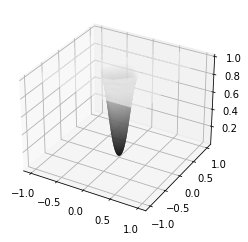

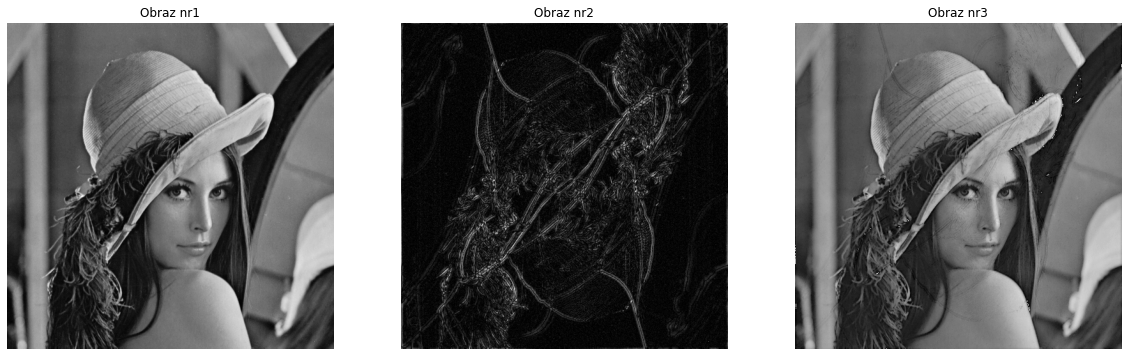

In [13]:
rozmiar=21
hanning=np.hamming(rozmiar)
hanning2d = np.outer(hanning, hanning)

#Filtr idealny

f_fcn_lena,mag_lena,pha_lena=fourier1(I_lena)

window_size=[rozmiar,rozmiar]

FSpaceRows = 2*np.fft.fftshift(np.fft.fftfreq(window_size[0]))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, window_size[1]]))
FSpaceCols = 2*np.fft.fftshift(np.fft.fftfreq(window_size[1]))
FSpaceColsM = np.outer(np.ones([1, window_size[0]]), FSpaceCols)    
FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

Filter_gorno = FreqR >= 0.2
FilterF = Filter_gorno


FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3),flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)

FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)


Filtr_all=hanning2d*FilterFI

Filtr_bor = cv2.copyMakeBorder(Filtr_all,246,245,246,245,cv2.BORDER_CONSTANT,value=0)

Filtr_bor = Filtr_bor.astype("float32")
F_fcn_filtr = cv2.dft(Filtr_bor,flags=cv2.DFT_COMPLEX_OUTPUT)
F_fcn_filtr = np.fft.fftshift(F_fcn_filtr, [0,1])

F_fcn_filtr_abs = np.abs(F_fcn_filtr)

lenaSize=I_lena.shape
FSpaceRows_512 = 2*np.fft.fftshift(np.fft.fftfreq(lenaSize[0]))
FSpaceRowsM_512 = np.outer(FSpaceRows_512, np.ones([1, lenaSize[1]]))
FSpaceCols_512 = 2*np.fft.fftshift(np.fft.fftfreq(lenaSize[1]))
FSpaceColsM_512 = np.outer(np.ones([1, lenaSize[0]]), FSpaceCols_512)  


figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM_512, FSpaceColsM_512, F_fcn_filtr_abs[:,:,0], rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)



F_lena_filtr = f_fcn_lena*F_fcn_filtr_abs

lena_ifft_2 = inversja(F_lena_filtr)
diff_2 = np.abs(I_lena-lena_ifft_2)

plot_3(I_lena,lena_ifft_2,diff_2)
